# Time Series for Python with PyFlux
   
[Ross Taylor](http://rjt1990.github.io)

[@rosstaylor90](http://www.twitter.com/rosstaylor90)

# About Me

- Financial Engineer, [Alpima](http://www.alpima.net)
- MPhil Economics, Cambridge
- **GitHub:** [RJT1990](http://www.github.com)  | **Twitter:** [@rosstaylor90](http://www.twitter.com)

# About PyFlux

New time series library which contains several model types including:

- State space models
- Score-driven models
- Gaussian process models

and more...

[GitHub](http:/www.github.com/RJT1990/pyflux) & [PyFlux.com](http:/www.pyflux.com/)

## Other great libraries for time series



- **statsmodels** : has the well-known time series methods.


- Probabilistic programming libraries: **PyMC3**, **PyStan**, **edward**


- Machine learning techniques from **scikit-learn**

# Dynamic Coefficient Models

- Today I will illustrate dynamic coefficients models in PyFlux. 

- The main example I will focus on is from finance.

- For those that find finance annoying, I have some other examples too, so don't freak out like this guy did:

<img src="pi.jpg", align="center", width="1500">
*Pi (1998) - Darren Aronofsky*

## **Our Problem** : Dynamic betas 

In finance we can think about a stock having:
- a *systematic* component: market-related
- a *residual* component: stock-specific

**Simplest model:** linear regression of a stock's excess returns on the market's excess returns

$$ r^{Stock}_{t} = \alpha^{Stock} + \beta^{Stock}{r^{Market}_{t}} + \epsilon^{Stock}_{t} $$ 

$\beta$ is the key to calculating the systematic return:

$$ \beta^{Stock} = \frac{\text{Cov}\left(r^{Stock},r^{Market}\right)}{\text{Var}\left(r^{Market}\right)} $$ 

**Question:** is $\beta$ likely to be stable over time?

- $\text{Var}\left(r^{Market}\right)$ - 'clusters' in periods of market turbulence
- $\text{Cov}\left(r^{Stock},r^{Market}\right)$ - nature of relationship can change

## Let's import what we need

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from datetime import datetime
from pandas.io.data import DataReader
import pyflux as pf

%matplotlib inline 

In [3]:
a = DataReader('AMZN',  'yahoo', datetime(2012,1,1), datetime(2016,6,1))
a_returns = pd.DataFrame(np.diff(np.log(a['Adj Close'].values)))
a_returns.index = a.index.values[1:a.index.values.shape[0]]
a_returns.columns = ["Amazon Returns"]

spy = DataReader('SPY',  'yahoo', datetime(2012,1,1), datetime(2016,6,1))
spy_returns = pd.DataFrame(np.diff(np.log(spy['Adj Close'].values)))
spy_returns.index = spy.index.values[1:spy.index.values.shape[0]]
spy_returns.columns = ['S&P500 Returns']

one_mon = DataReader('DGS1MO', 'fred',datetime(2012,1,1), datetime(2016,6,1))
one_day = np.log(1+one_mon)/365

returns = pd.concat([one_day,a_returns,spy_returns],axis=1).dropna()
excess_m = returns["Amazon Returns"].values - returns['DGS1MO'].values
excess_spy = returns["S&P500 Returns"].values - returns['DGS1MO'].values
final_returns = pd.DataFrame(np.transpose([excess_m,excess_spy, returns['DGS1MO'].values]))
final_returns.columns=["Amazon","SP500","Risk-free rate"]
final_returns.index = returns.index

## Data for our primary example

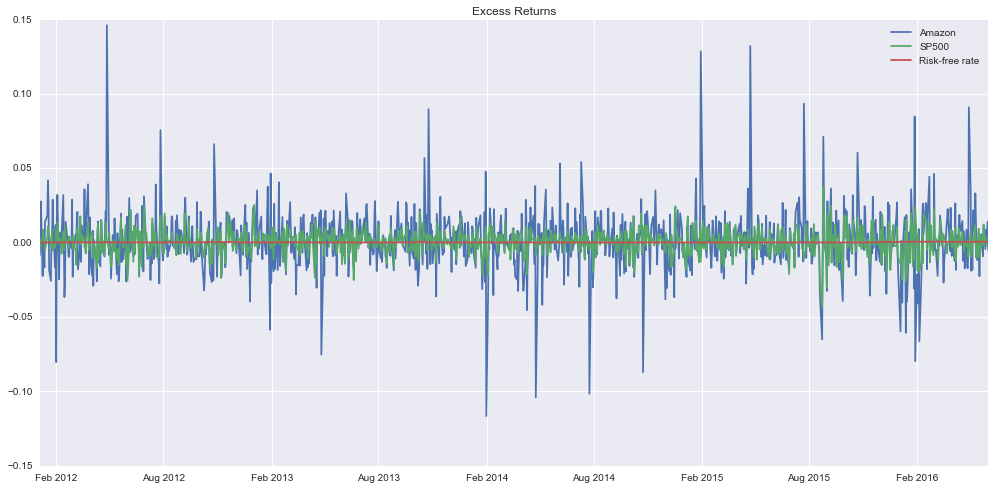

In [4]:
plt.figure(figsize=(17,8))
plt.title("Excess Returns")
x = plt.plot(final_returns);
plt.legend(iter(x), final_returns.columns);

Let's build some models!

# Model 1: Gaussian State Space Models

## Unobserved Components

The series $y$ has a state space form:

$$ y_{t} = Z_{t}\alpha_{t} + \epsilon_{t}  $$
$$ \alpha_{t} = T_{t}\alpha_{t-1} + \eta_{t}  $$
$$ \epsilon_{t} \sim N\left(0,\Sigma_{\epsilon}\right) $$
$$ \eta_{t} \sim N\left(0,\Sigma_{\eta}\right) $$


Closed-form solution to this problem is through the Kalman filter and smoothing algorithms.

## State Space Models are Flexible

State space models have many models as special cases:
    
- ARIMA models
- Dynamic regression models
- Local level models
- Local linear trend and cyclical models
- Paired comparison / power rating models

Let's quickly look at some of these models.

In [5]:
nile = pd.read_csv('https://vincentarelbundock.github.io/Rdatasets/csv/datasets/Nile.csv')
nile.index = pd.to_datetime(nile['time'].values,format='%Y')

<img src='nile.jpg', align='center', width="1500">
<center><font size='2'>©Jiseon Shin - View of the Nile and the desert banks</font></center>

## Discharge from the Nile River

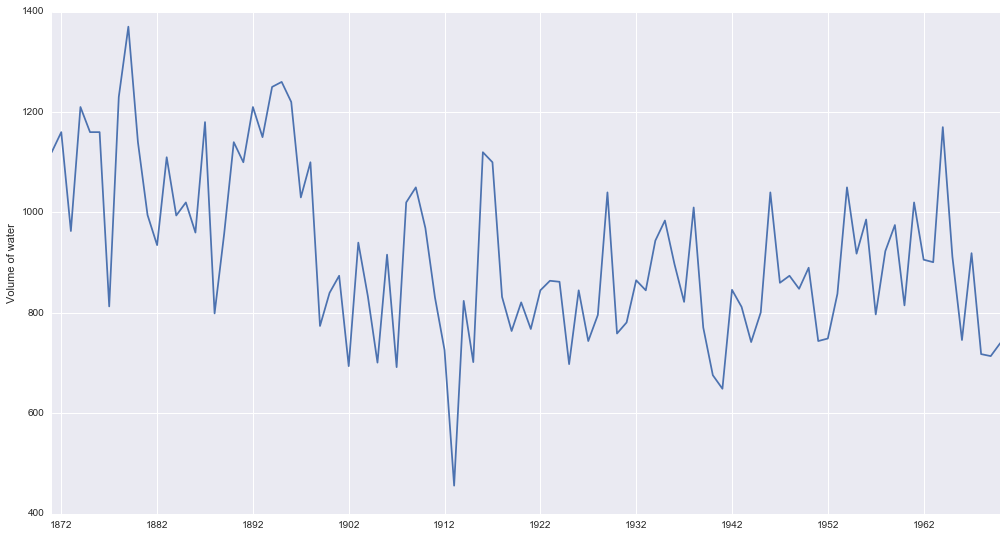

In [6]:
plt.figure(figsize=(17,9));
plt.plot(nile['Nile']);
plt.ylabel('Volume of water');

## Local Level Model for Nile River Discharge

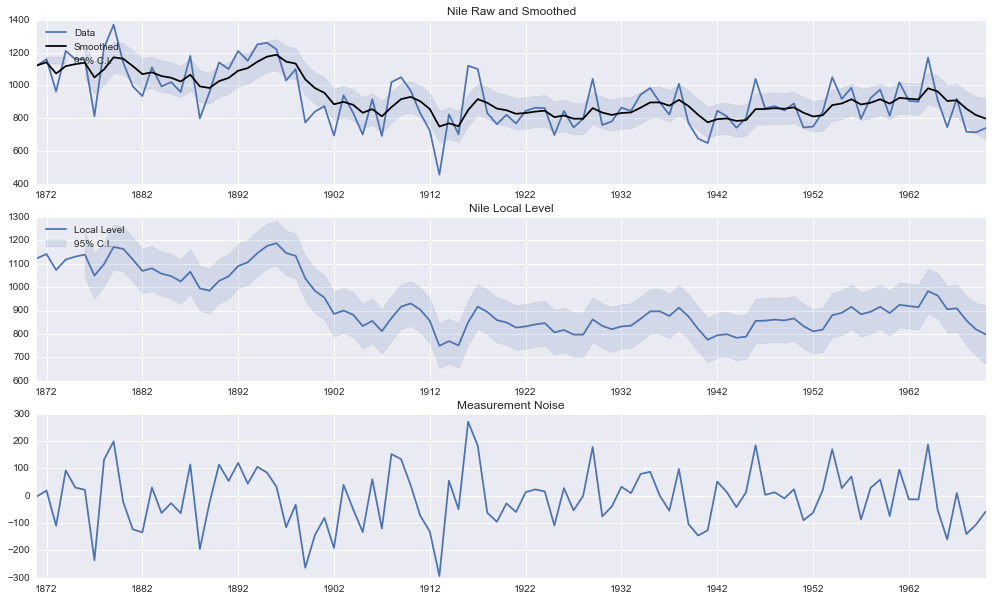

In [7]:
nile_model = pf.LLEV(data=nile,target='Nile')
nile_model.fit()
nile_model.plot_fit(figsize=(17,10))

In [10]:
growthdata = pd.read_csv('http://www.pyflux.com/notebooks/GDPC1.csv')
USgrowth = pd.DataFrame(np.log(growthdata['VALUE']))
USgrowth.index = pd.to_datetime(growthdata['DATE'])
USgrowth.columns = ['Logged US Real GDP']

## Logged US Real GDP

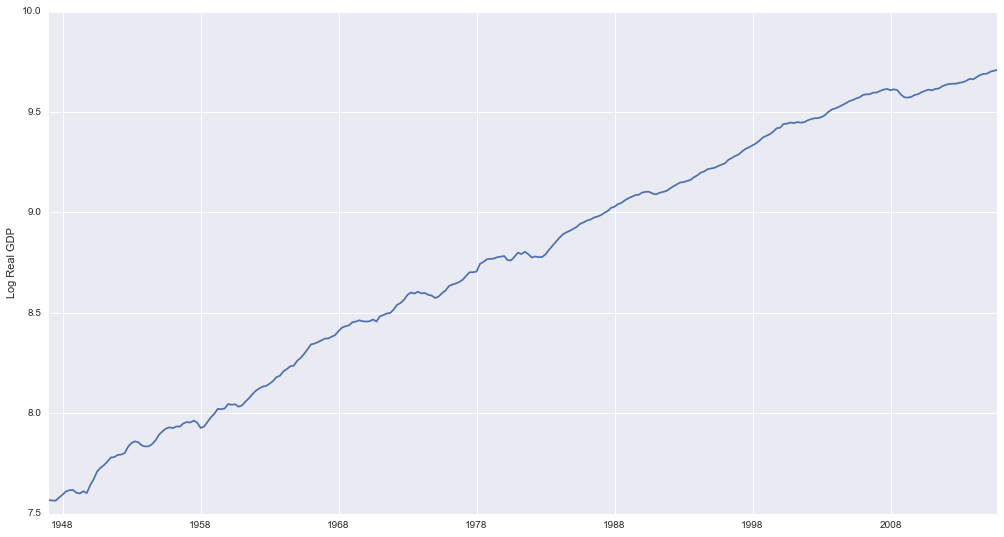

In [11]:
plt.figure(figsize=(17,9));
plt.plot(USgrowth['Logged US Real GDP']);
plt.ylabel('Log Real GDP');

## Local Linear Trend Model for US GDP data

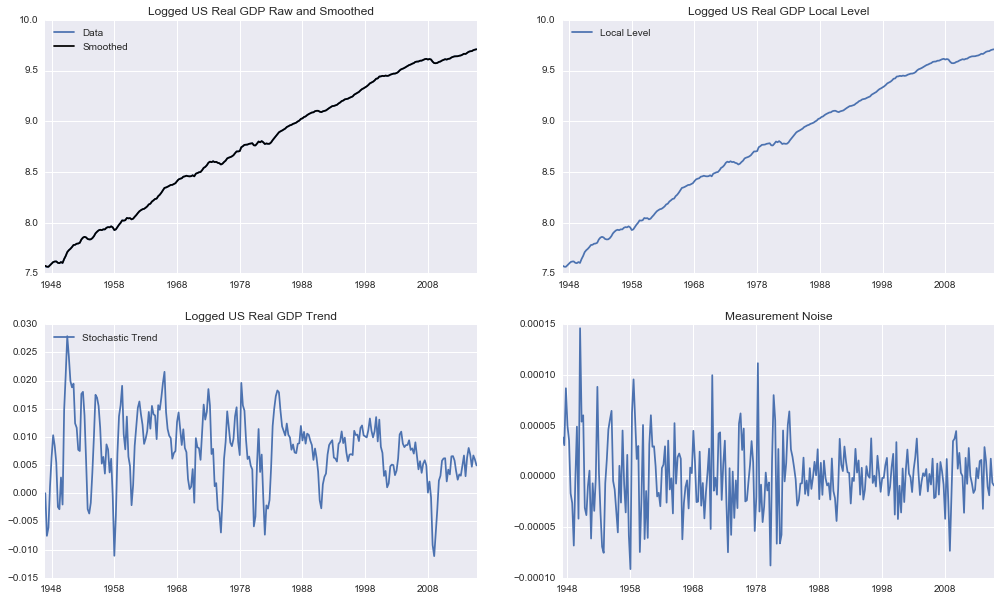

In [12]:
us_model = pf.LLT(data=USgrowth)
us_model.fit()
us_model.plot_fit(intervals=False,figsize=(17,10))

### (Forecasting is easy by the way)

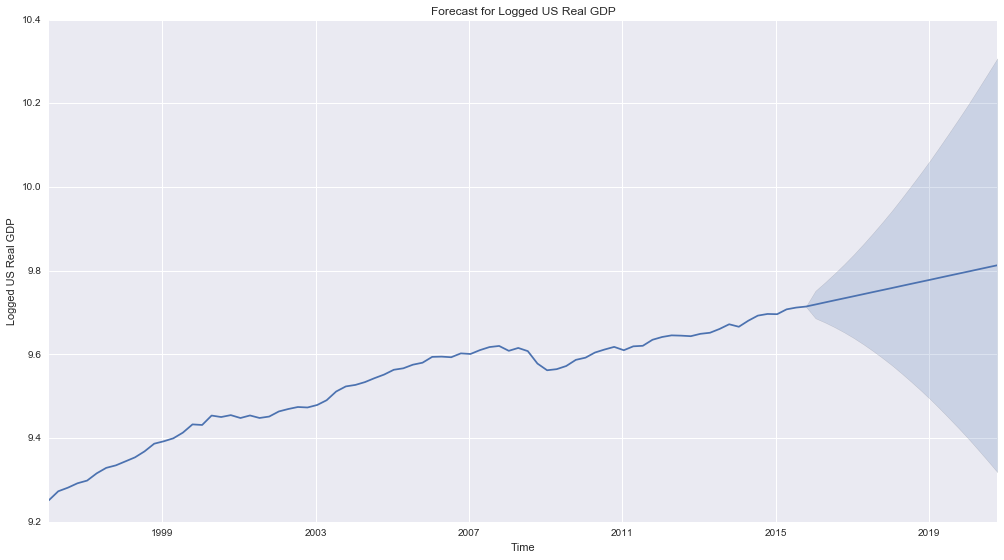

In [14]:
us_model.plot_predict(h=20,past_values=80,figsize=(17,9))

## Back to our Dynamic Regression Problem...

- Put regressors in $Z_{t}$, set $T_{t}=I$:

$$ y_{t} = \beta_{t}x_{t} + \epsilon_{t}  $$
$$ \beta_{t} = \beta_{t-1} + \eta_{t}  $$
$$ \epsilon_{t} \sim N\left(0,\Sigma_{\epsilon}\right) $$
$$ \eta_{t} \sim N\left(0,\Sigma_{\eta}\right) $$

This is a time-varying coefficient model.

Set up the model in PyFlux using **patsy** notation:


In [15]:
model = pf.DynLin('Amazon ~ SP500',data=final_returns)
x = model.fit() # MLE is default for this model; feel free to go Bayes
# x.summary() (if you want the full summary table)

## Component Plot

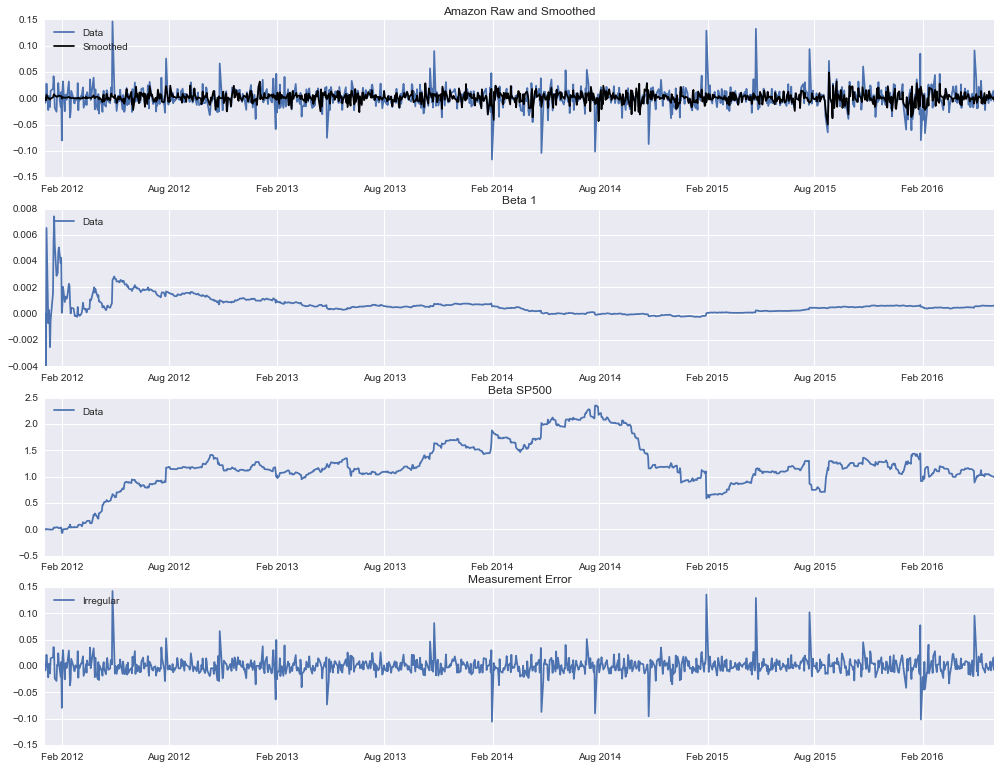

In [19]:
model.plot_fit(intervals=False,figsize=(17,13))

In [17]:
states, V, _, _, _ = model._model(model.data,model.parameters.get_parameter_values())
mu, V = model.smoothed_state(model.data,model.parameters.get_parameter_values())
gaussian_beta_filtered = states[1]
gaussian_beta_smoothed = x.states[1]

## Amazon Beta from Kalman Filter/Smoother

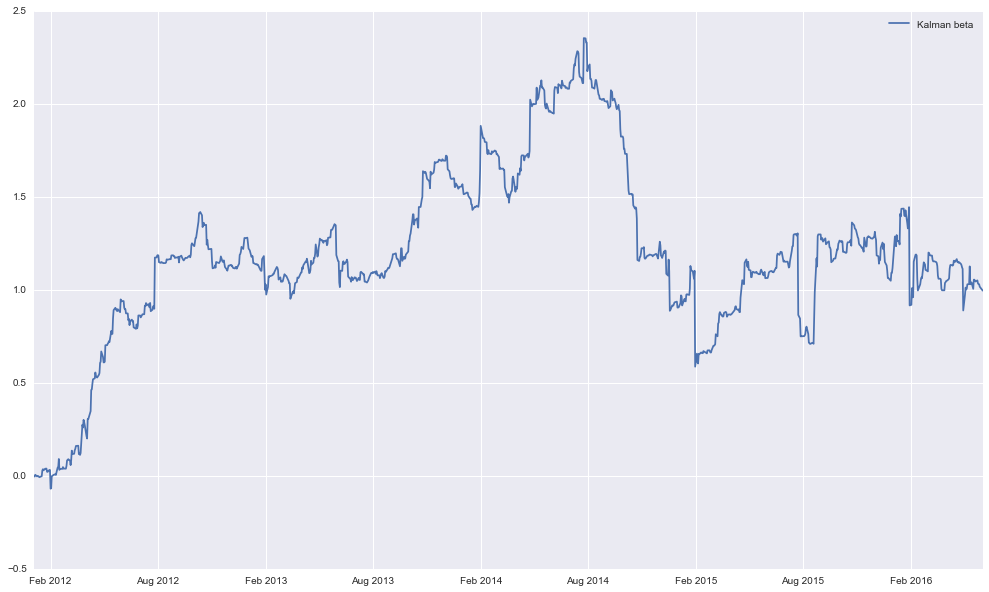

In [20]:
plt.figure(figsize=(17,10))
plt.plot(model.index[:],gaussian_beta_smoothed[:-1],label='Kalman beta');
plt.legend();

## Summary

- Gaussian State Space models encompass many model types.


- These models are quick because closed-form solution exists.


- **Limitation:** The Kalman filter is only optimal under the assumption of normality, e.g. it lacks robustness to heavy-tails. 

# Model 2: Score-Driven Models

## Follow the Score

- Known as Dynamic Conditional Score (DCS) or Generalized Autoregressive Score (GAS) models.

$$ p\left(y_{t}\mid\theta_{t}\right) $$

$$ \theta_{t} = \theta_{t-1} + \eta{H_{t-1}^{-1}S_{t-1}}$$

- Uses the conditional score $S_{t}$ of the distribution as an approximation to a latent stochastic process.


- These are state space models that can be written in closed-form for non-normal distributions.

## Example: Poisson Density

### Likelihood Derivation of the Score

$$ p(y_{t};\lambda_{t}) = \frac{\lambda_{t}^{y_{t}}\exp{(-\lambda_{t})}}{y_{t}!} $$

$$ \lambda_{t} = \exp{(\theta_{t})}$$

$$ \log{p}(x_{t};\theta_{t}) = {y_{t}\theta_{t}-\exp{(\theta_{t})}} - \log{y_{t}!}  $$

$$ \frac{\partial\log{p}(y_{t};\theta_{t})}{\partial\theta_{t}} = y_{t} - \exp{(\theta_{t})} = S_{t}$$

$$ \frac{\partial^{2}\log{p}(y_{t};\theta_{t})}{\partial\theta_{t}^{2}} =- \exp{(\theta_{t})} = -H_{t} $$

### Using the score to build models

$$ \theta_{t} = \theta_{t-1} + \eta\left(\frac{y_{t}}{\exp{(\theta_{t})}}-1\right)$$

- Above is a simple random walk DCS model.


- DCS/GAS models are far more general than this. You can use the score to construct any state space model.


- Why the score? It's the optimal update in a KL-divergence sense; see Blasques, Koopman & Lucas (2014).

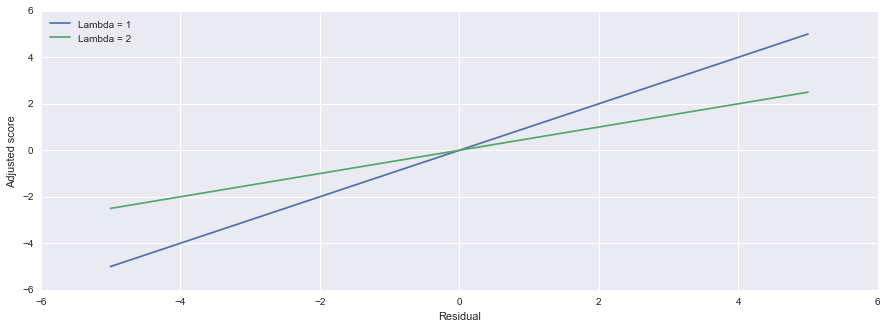

In [21]:
def poisson_score(eps,lam):
    return eps/lam

plt.figure(figsize=(15,5))
plt.plot(np.linspace(-5,5),poisson_score(np.linspace(-5,5),1),label="Lambda = 1")
plt.plot(np.linspace(-5,5),poisson_score(np.linspace(-5,5),2),label="Lambda = 2")
plt.legend(loc=2)
plt.ylabel("Adjusted score");
plt.xlabel("Residual");

### Information-Thereotic Interpretation

Reexpress Poisson density in terms of a Bregman divergence:

$$ p(y_{t};\lambda_{t}) = \exp{(y_{t}\log(\lambda_{t})-\lambda_{t}-\log(y_{t}!)}) $$

$$ p(y_{t};\lambda_{t}) = \exp{(y_{t}\log(\lambda_{t})-\lambda_{t}-y_{t}\log(y_{t})+y_{t} -g(y_{t}))}) $$

$$ p(y_{t};\lambda_{t}) = \exp{(-D\left(y_{t},\theta_{t}\right) -g(y_{t})}) $$

$D$ is the relative entropy/KL divergence: 

$$ D\left(y_{t},\lambda_{t}\right) = y_{t}\log{\frac{y_{t}}{\lambda_{t}}} - y_{t} + \lambda_{t} $$

Minimizing the KL divergence:

$$ D\left(y_{t},\lambda_{t}\right) = y_{t}\log{\frac{y_{t}}{\lambda_{t}}} - y_{t} + \lambda_{t} $$

$$ \frac{\partial{D\left(y_{t},\lambda_{t}\right)}}{\partial\lambda_{t}} = -{\frac{y_{t}}{\lambda_{t}}} + 1 = -\frac{\partial\log{p}(y_{t};\lambda_{t})}{\partial\lambda_{t}} $$

Simply the negative of the score. The score reduces the local KL (reduces information loss).

### Application of Poisson-GAS for a very simple dataset

<img src='derbyforest.png',width=1000>

In [58]:
eastmidlandsderby = pd.read_csv('eastmidlandsderby.csv')
eastmidlandsderby.head()

,Date,Forest,Derby,ForestHome,DerbyHome
0,01-10-1892,3,2,0,1
1,28-01-1893,1,0,1,0
2,09-12-1893,4,3,0,1
3,30-12-1893,4,2,1,0
4,08-09-1894,2,4,0,1


### A Brief History

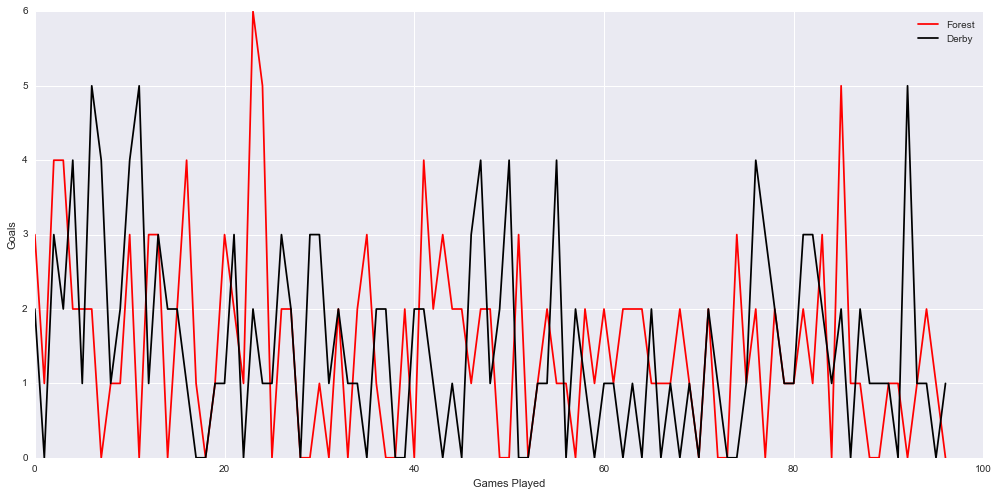

In [23]:
plt.figure(figsize=(17,8))
plt.plot(eastmidlandsderby['Forest'],label='Forest',color='r')
plt.plot(eastmidlandsderby['Derby'],label='Derby',color='k')
plt.ylabel('Goals')
plt.xlabel('Games Played')
plt.legend();

### Empirical Distribution

In [24]:
derby_counts = eastmidlandsderby['Derby'].value_counts().sort_index()
forest_counts = eastmidlandsderby['Forest'].value_counts().sort_index()

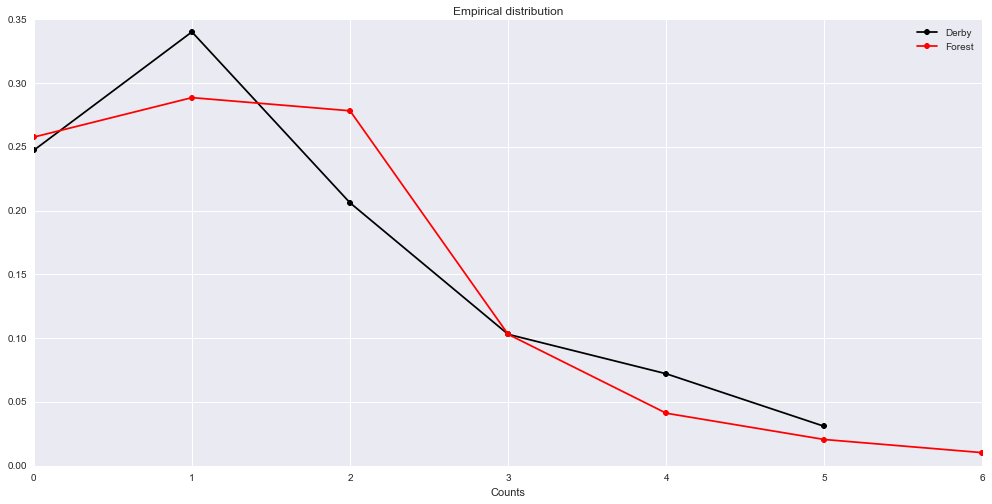

In [25]:
plt.figure(figsize=(17,8))
plt.plot(derby_counts/derby_counts.sum(),label='Derby',color='k',marker='8')
plt.plot(forest_counts/forest_counts.sum(),label='Forest',color='r',marker='8')
plt.title('Empirical distribution')
plt.xlabel('Counts');
plt.legend();

### Poisson Local Level Model

In [26]:
forest = pf.GASRegPoisson(formula='Forest~1',data=eastmidlandsderby)
forest.parameters.parameter_list[0].start = -1
x = forest.fit()

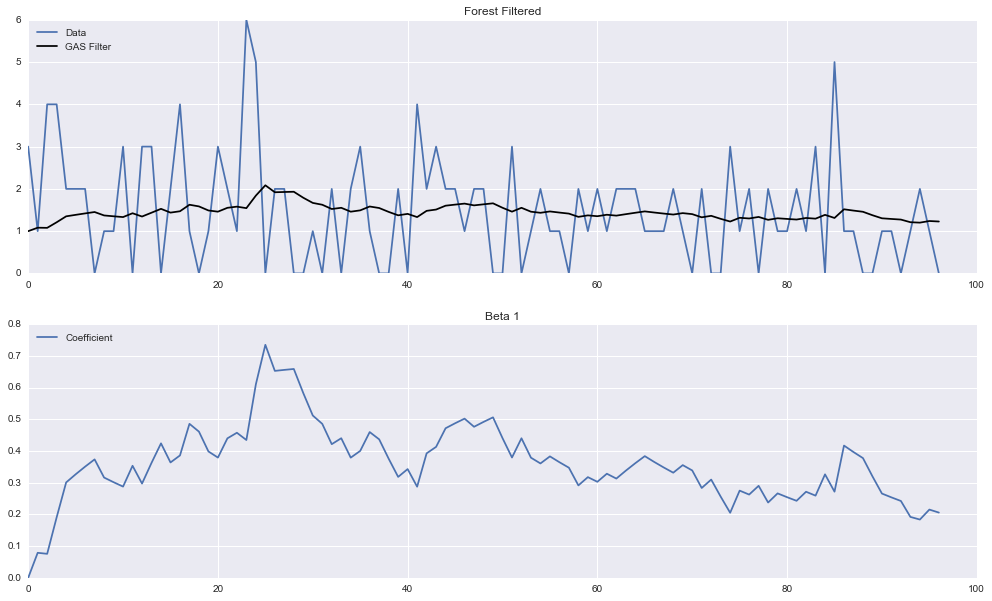

In [27]:
forest.plot_fit(figsize=(17,10))

### And with a home advantage effect...

In [28]:
forest2 = pf.GASRegPoisson(formula='Forest~1+ForestHome',
                           data=eastmidlandsderby)

In [29]:
forest2.parameters.parameter_list[0].start = x.parameters.parameter_list[0].value
forest2.parameters.parameter_list[1].start = -4.0
x2 = forest2.fit()

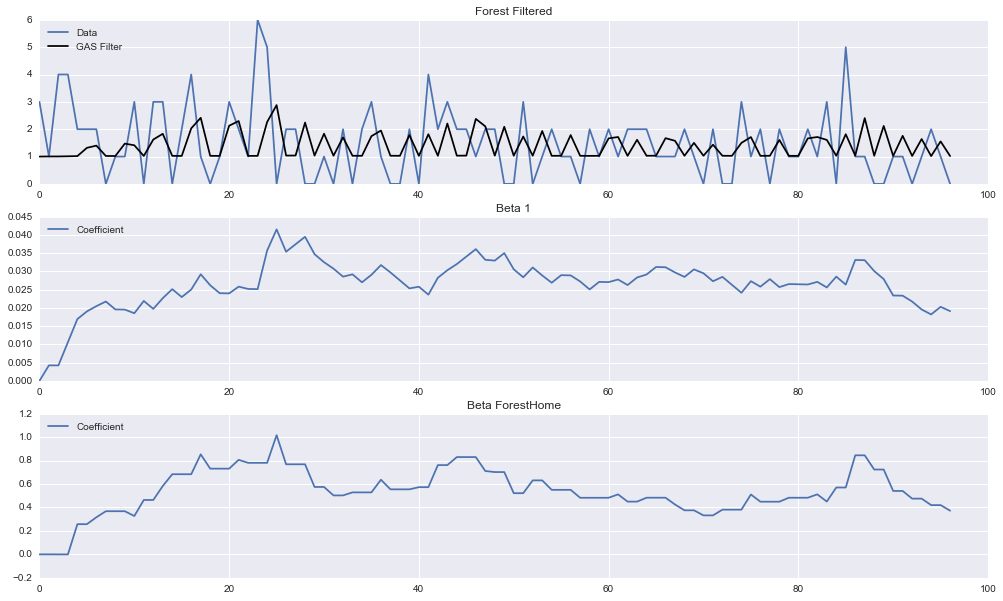

In [30]:
forest2.plot_fit(figsize=(17,10),intervals=False)

If we make the same model for Derby, we can combine the states and make a crude skill comparison over their history of head-to-heads:

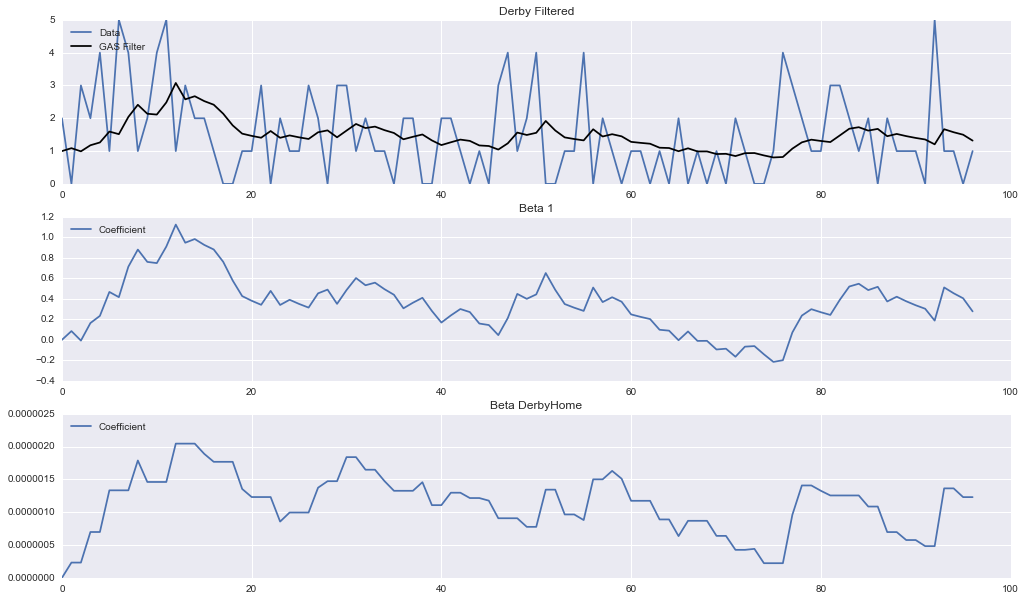

In [59]:
scum = pf.GASRegPoisson(formula='Derby~1+DerbyHome',data=eastmidlandsderby)
scum.parameters.parameter_list[0].start = -1
xscum = scum.fit()
scum.plot_fit(figsize=(17,10))

In [60]:
scum.index=pd.to_datetime(eastmidlandsderby['Date'],format='%d-%m-%Y')
skill_differential = (x2.states[0][:-1]+0.5*x2.states[1][:-1]) -(xscum.states[0][:-1]+0.5*xscum.states[1][:-1])
wwars=['26-12-1914','24-09-1921','25-01-1936','07-11-1953']

In [61]:
def plot_annotate():
    plt.xlabel('Games Played',fontsize=15);
    plt.ylabel("Skill Differential: Forest Superior if >0",fontsize=15)
    plt.ylim(-1.0,1.0)
    plt.axhline(0, color='black', linestyle='--', lw=2,alpha=0.4)
    plt.legend();
    
def plot_annotate2():
    plt.fill_between(wwars[0:2],-1.0,1.0,facecolor='black',alpha=0.05,label='WW1')
    plt.fill_between(wwars[2:4],-1.0,1.0,facecolor='black',alpha=0.05,label='WW2')
    plt.xlabel('Games Played',fontsize=15);
    plt.ylabel("Skill Differential",fontsize=15)
    plt.ylim(-1.0,1.0)
    plt.axhline(0, color='black', linestyle='--', lw=2,alpha=0.4)
    plt.legend();

###  Pride of the East Midlands

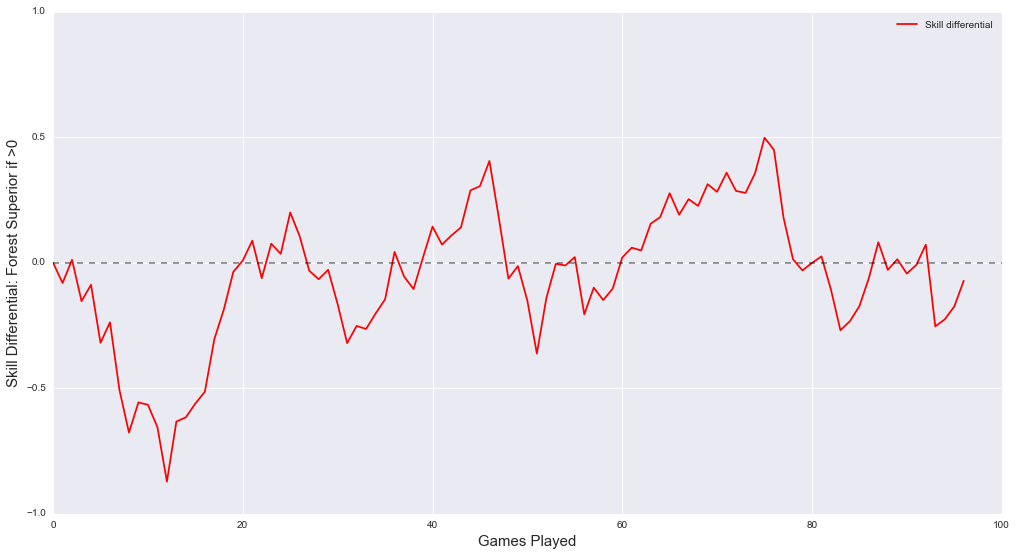

In [62]:
plt.figure(figsize=(17,9))
plt.plot(skill_differential,c='red',label='Skill differential')
plot_annotate()

<font size=4>* I don't care about Leicester</font>

### Some obvious limitations

- Have assumed regularly spaced intervals (laziness).
- It's a head-to-head dataset; can't infer much from it.

But this is just for fun and illustration. Some more fun examples:

- Cam/Ox Boat Race - Durbin and Koopman (2012)
- England/Scotland fixtures - Harvey and Fernandes (1989)

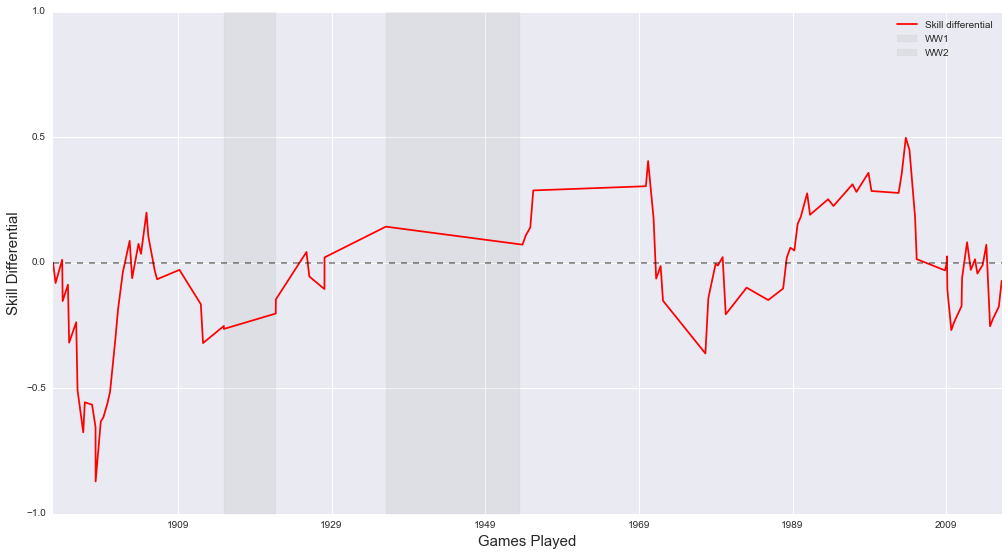

In [35]:
plt.figure(figsize=(17,9))
plt.plot(scum.index,skill_differential,c='red',label='Skill differential')
plot_annotate2()

## Back to the Finance

For our dynamic beta problem we will use a t-distribution to account for heavy tails. The score leads to Winsorization through the shape $\nu$.


$$ S_{t} = \left(\frac{\nu+1}{\nu}\right)\frac{X_{t}(y_{t}-X_{t}\beta_{t})}{\sigma^{2} + \frac{(y_{t}-X_{t}\beta_{t})^{2}}{\nu}} $$ 


Just as the t-distribution becomes Normal as $\nu\to\infty$, the property carries through to the score, which becomes $ S_{t} = \frac{X_{t}(y_{t}-X_{t}\beta_{t})}{\sigma^{2}} $, which is equivalent to the score of a GAS with a normal distribution. 

### Visualizing the Score

In [36]:
def t_score(eps,v,sigma2):
    return ((v+1)/v)*(eps)/(sigma2 + np.power(eps,2)/v)

In [37]:
def plot_score():
    plt.figure(figsize=(17,10))
    plt.title("Score of t-distribution with sigma2=1")
    plt.plot(np.linspace(-5,5),t_score(np.linspace(-5,5),100,2),label="v = 100 (basically Normal)")
    plt.plot(np.linspace(-5,5),t_score(np.linspace(-5,5),4,2),label="v = 4 (heavy tails)")
    plt.legend(loc=2)
    plt.ylabel("Score");
    plt.xlabel("Residual");

### The Redescending Property

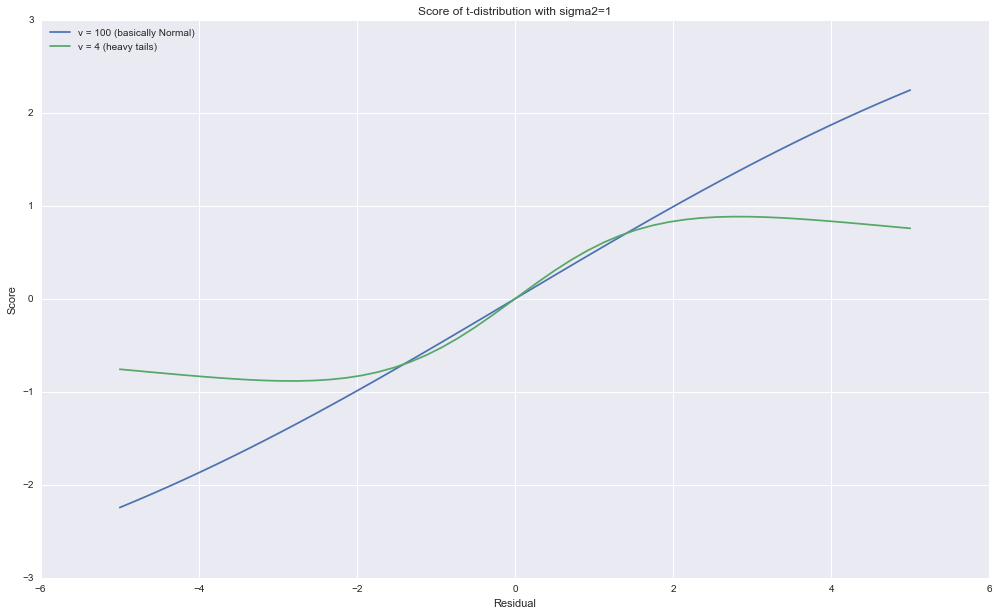

In [38]:
plot_score()

See Harvey and Luati (2012) for the result. You may have seen this on Gelman's blog as an example of the "redescending" phenomenon:

http://andrewgelman.com/2014/12/07/subtleties-measurement-error-models-evaluation-wacky-claims/.

- Redescending M-estimators from the robustness literature have same property - but usually have an arbitary cutoff. E.g: a normal response until point $k$ but constant afterwards. 


- The score of the t-distribution has this property naturally because its tails aren't exponentially bounded.

### Dynamic t regression in PyFlux

In [39]:
model = pf.GASRegt('Amazon ~ SP500',data=final_returns)
model.parameters.parameter_list[1].start = -2
x = model.fit()
# x.summary()

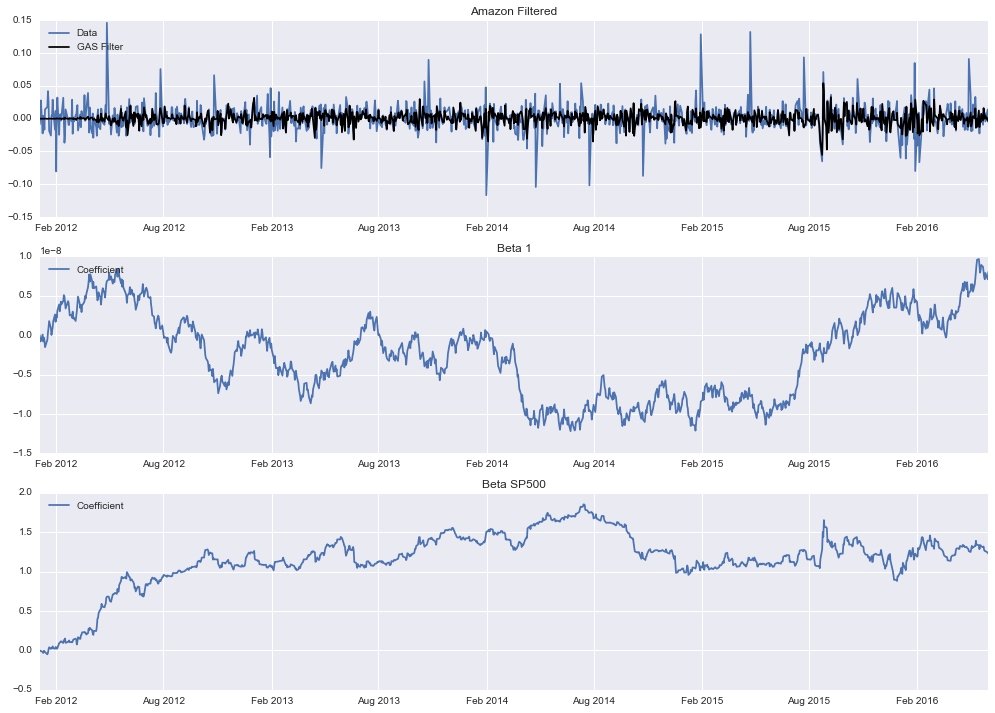

In [40]:
model.plot_fit(intervals=False,figsize=(17,12))

In [41]:
t_beta = x.states[1]

## Kalman Filter vs DCS-t Filter

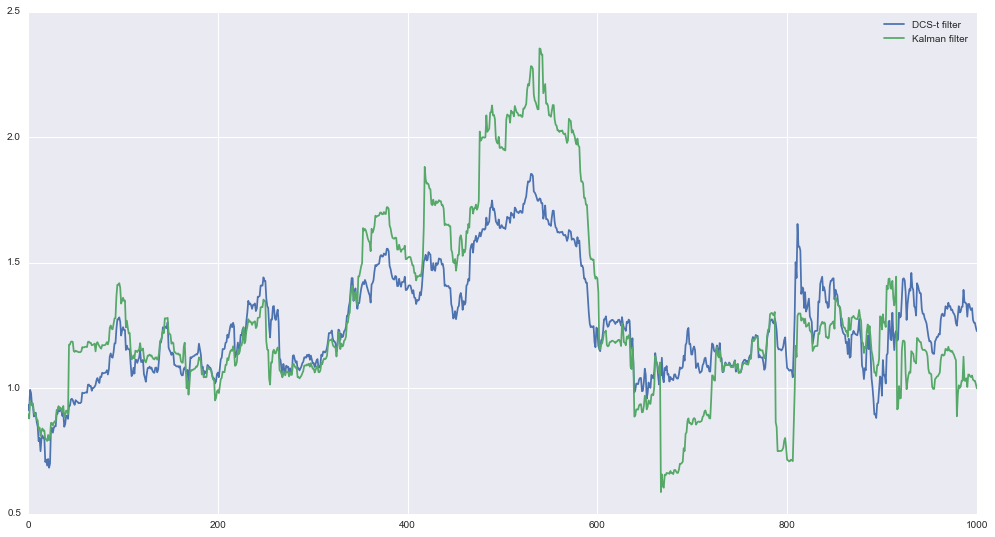

In [42]:
plt.figure(figsize=(17,9))
plt.plot(t_beta[100:-1],label='DCS-t filter')
plt.plot(gaussian_beta_filtered[100:-1],label='Kalman filter')
plt.legend()
plt.show()

## Summary

- Score-driven models are quick to estimate and effective.


- We've derived a more robust filter for heavy-tailed data.


- **Limitation:** what are we actually approximating? What is the probabilistic interpretation of the latent process?

## Model 3: Non-Gaussian State Space Models

## The State Space Form

We now have a potentially non-normal measurement density:

$$ y_{t} = p\left(\theta_{t};\psi\right)  $$
$$ \theta_{t} = f(Z_{t}\alpha_{t})$$
$$ \alpha_{t} = T_{t}\alpha_{t-1} + \eta_{t}  $$
$$ \eta_{t} \sim N\left(0,\Sigma_{\eta}\right) $$

## Ways to tackle this problem

- **Classical** : importance sampling, numerical integration, variational inference


- **Bayesian** : MCMC, SMC, variational inference, INLA, EP

PyFlux uses a variant of black box variational inference (BBVI). VI is very hot right now because of its potential to scale complex probabilistic models to larger datasets, including time series models.

## Variational Inference

We approximate the posterior $p\left(\theta\mid{y}\right)$ with a variational distribution $q\left(\theta\mid{\phi}\right)$, with the goal being to minimize the KL divergence:

$$ KL\left[q\left(z\right)\mid\mid{p}\left(z\right)\right] = -E_{q}\left(\log\left(\frac{p\left(\theta\mid{y}\right)}{q\left(\theta\mid{\phi}\right)}\right)\right)$$

$$ = -E_{q}\left[\log\left({p\left(\theta\mid{y}\right)}\right)\right] + E_{q}\left[\log\left({q\left(\theta\mid{\phi}\right)}\right)\right] $$

Can indirectly minimize KL by maximizing the evidence lower bound:

$$ ELBO = E_{q}\left[\log\left({p\left(\theta,{y}\right)}\right)\right] - E_{q}\left[\log\left({q\left(\theta\mid{\phi}\right)}\right)\right] $$

In [55]:
import matplotlib.mlab as mlab

def approx_plot_1():
    prior = np.linspace(0-1*3.5,0+1*3.5,100)
    likelihood = np.linspace(-4-1*3.5,-4+1*3.5,100)
    plt.figure(figsize=(17,5))
    plt.plot(prior,mlab.normpdf(prior,0,1),label='Approx');
    plt.plot(likelihood,mlab.normpdf(likelihood,-4,1),label='Actual');
    plt.legend();
    
def approx_plot_2():
    prior = np.linspace(0-1.1*3.5,0+1.1*3.5,100)
    likelihood = np.linspace(0-1*3.5,0+1*3.5,100)
    plt.figure(figsize=(17,5))
    plt.plot(prior,mlab.normpdf(prior,0,1),label='Approx');
    plt.plot(likelihood,mlab.normpdf(likelihood,0,1.01),label='Actual');
    plt.legend();    

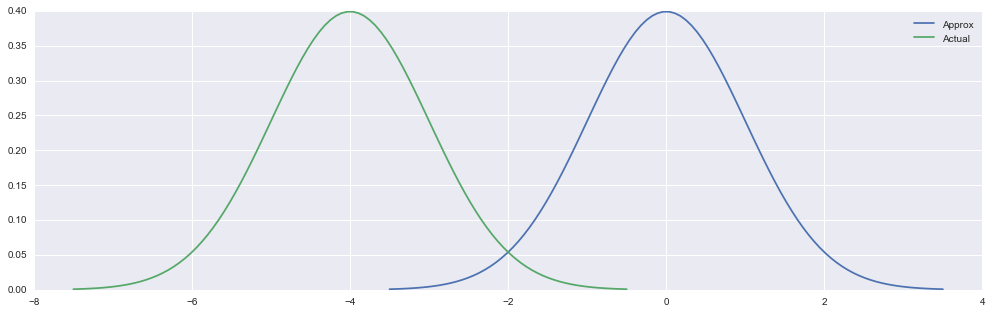

In [56]:
approx_plot_1()

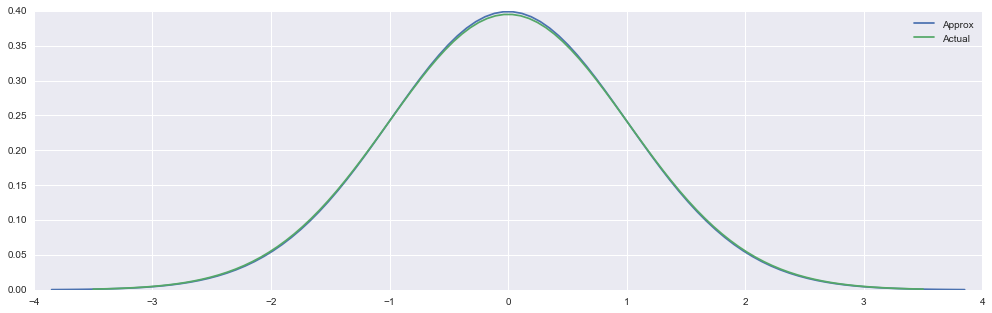

In [57]:
approx_plot_2()

## BBVI - Ranganeth (2013)

- A stochastic form of variational inference.


- BBVI uses Monte Carlo gradients for stochastic optimization; employs variance reduction techniques for efficiency.


- Popular choices of an approximate distribution: mean-field family, full rank Gaussian, structural.


- See paper for details - also O-BBVI (Blei  et al 2016) which cleverly exploits a property of importance sampling

## BBVI Continued

For state space models, there is an approximation trade-off:

- **Mean field** : fastest but underestimates state dependence and state variances. But generally okay for prediction.


- **Full rank Gaussian** : not very scalable. Consider a $N$ length time series. Your covariance matrix for *each* state vector is going to have $N(N-1)/2$ approximating parameters.

PyFlux currently has mean-field implemented.

## BBVI: Where is the sweet spot?

The sweet spot between accuracy and scalability for state space models lies between the mean-field and full-rank Gaussian families:

- Use sparse covariance matrices - Archer et al (2015)
- Copula variational inference - Tran et al (2015)

BBVI can accomodate these assumptions easily. Will look to get into PyFlux in near-future.

## Poisson Local Level Model

In [43]:
model = pf.NLLEV.Poisson(data=eastmidlandsderby,target='Forest')
x = model.fit(iterations=10000,print_progress=False)
#x.summary()

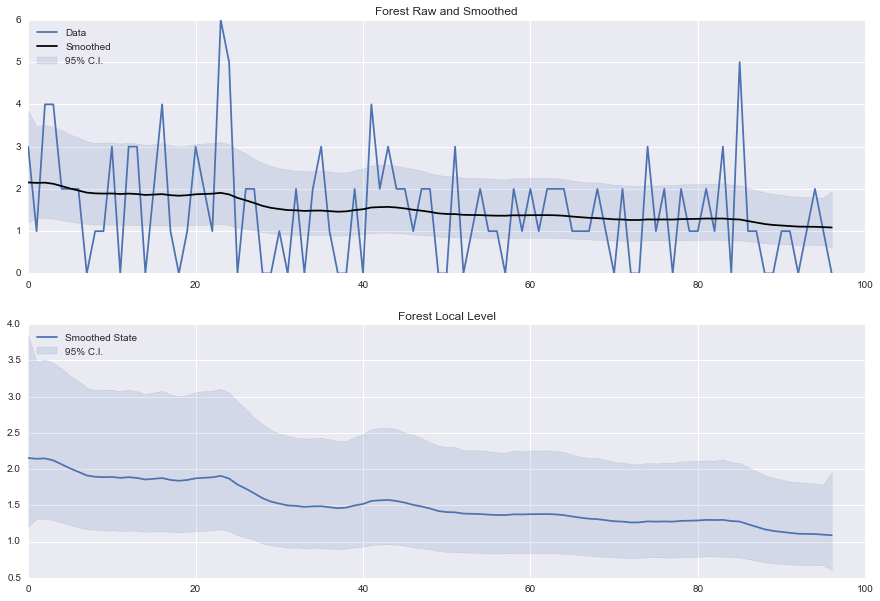

In [44]:
model.plot_fit(figsize=(15,10))

## Poisson Regression Model

In [47]:
ng_model = pf.NDynLin.Poisson(data=eastmidlandsderby,
                        formula='Forest ~ ForestHome')
ng_x = ng_model.fit(iterations=10000,start_diffuse=False,print_progress=False)

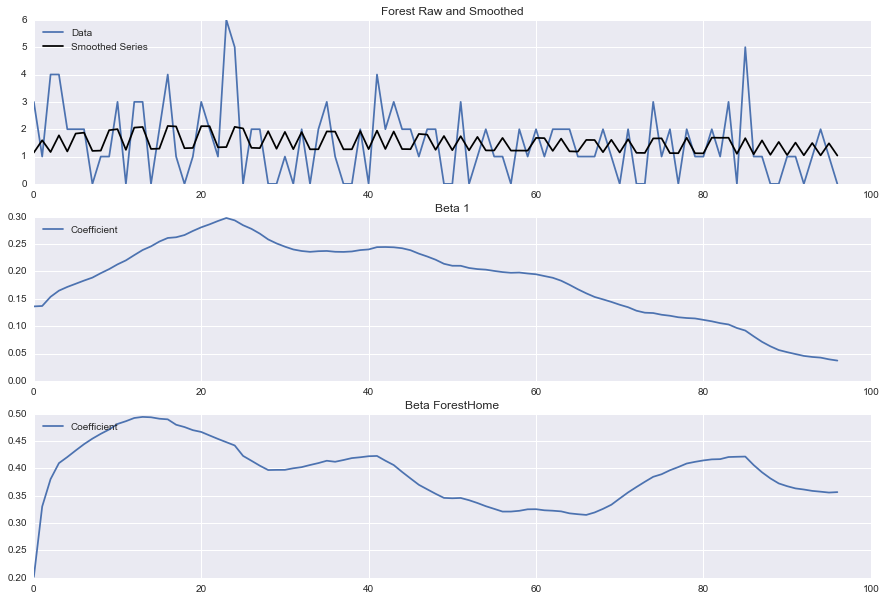

In [50]:
ng_model.plot_fit(intervals=False,figsize=(15,10))

## Animation (from naive starting points)

In [42]:
from datetime import timedelta

class YouTubeVideo(object):
    def __init__(self, id, width=700, height=400, start=timedelta()):
        self.id = id
        self.width = width
        self.height = height
        self.start = start.total_seconds()

    def _repr_html_(self):
        return """
            <iframe
                width="%i"
                height="%i"
                src="http://www.youtube.com/embed/%s?start=%i"
                frameborder="0"
                allowfullscreen
            ></iframe>
        """%(self.width, self.height, self.id, self.start)

<center>< animation here ></center>

## Dynamic t Regression

In [51]:
ng_model = pf.NDynLin.t(data=final_returns,
                        formula='Amazon ~ -1 + SP500')
ng_x = ng_model.fit(iterations=10000,start_diffuse=False)
#ng_x.summary()

10% done : ELBO is -25240.5012476
20% done : ELBO is -16095.7416883
30% done : ELBO is -12826.1334243
40% done : ELBO is -12286.4684433
50% done : ELBO is -12700.7308382
60% done : ELBO is -12351.7785848
70% done : ELBO is -13108.6079088
80% done : ELBO is -12772.4416833
90% done : ELBO is -12504.2748435
100% done : ELBO is -12671.8101186

Final model ELBO is -12383.0708447


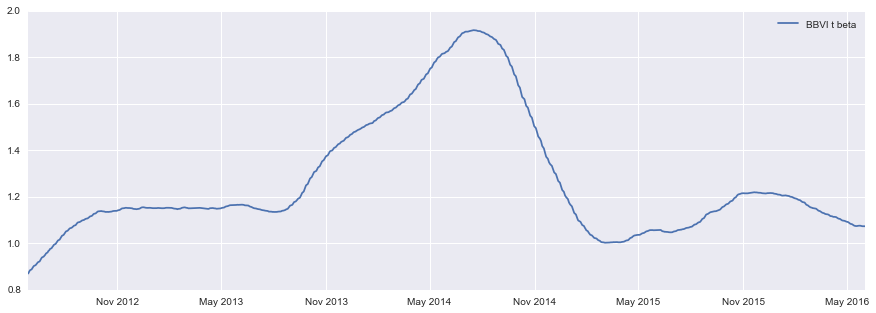

In [52]:
plt.figure(figsize=(15,5))
plt.plot(ng_model.index[100:],ng_x.states[0][100:],label='BBVI t beta')
plt.legend()
plt.show()

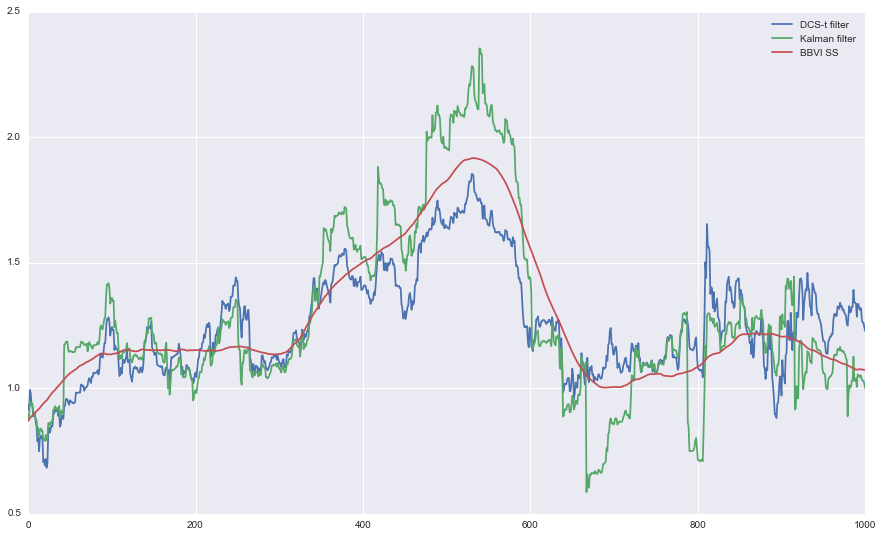

In [57]:
plt.figure(figsize=(15,9))
plt.plot(t_beta[100:-1],label='DCS-t filter')
plt.plot(gaussian_beta_filtered[100:-1],label='Kalman filter')
plt.plot(ng_x.states[0][100:-1],label='BBVI SS')
plt.legend();

<font size=3>- The BBVI method here only produces smoothing, not filtering - so not an exact like-for-like comparison.</font>

## Summary

- Non-Gaussian state space models are the direct way to attack the signal extraction problem for Non-Gaussian data.


- Advances in variational inference hold promise for making these models scale to larger datasets.


- **Limitation:** restrictive in the kind of relationships they can model (form of the state equation).

# Comparisons and Extensions

## Which Model to Choose?

Which model should you use for your application?

- Is the data close to normal? -> Gaussian state space


- Is your data non-normal? -> GAS or Non-Gaussian state space


GAS models are more scalable than fully probabilistic Non-Gaussian model, but  advances in stochastic VI are reducing the gap.

## Teasing Possible Extensions

- The regressions we have considered are  additive? Restrictive?


- What if we want to model volatility separately?


In [54]:
a = DataReader('AMZN',  'yahoo', datetime(2015,6,1), datetime(2016,6,1))
a_returns = pd.DataFrame(np.diff(np.log(a['Adj Close'].values)))
a_returns.index = a.index.values[1:a.index.values.shape[0]]
a_returns.columns = ["Amazon Returns"]

spy = DataReader('SPY',  'yahoo', datetime(2015,6,1), datetime(2016,6,1))
spy_returns = pd.DataFrame(np.diff(np.log(spy['Adj Close'].values)))
spy_returns.index = spy.index.values[1:spy.index.values.shape[0]]
spy_returns.columns = ['S&P500 Returns']

one_mon = DataReader('DGS1MO', 'fred',datetime(2015,6,1), datetime(2016,6,1))
one_day = np.log(1+one_mon)/365

returns = pd.concat([one_day,a_returns,spy_returns],axis=1).dropna()
excess_m = returns["Amazon Returns"].values - returns['DGS1MO'].values
excess_spy = returns["S&P500 Returns"].values - returns['DGS1MO'].values
final_returns = pd.DataFrame(np.transpose([excess_m,excess_spy, returns['DGS1MO'].values]))
final_returns.columns=["Amazon","SP500","Risk-free rate"]
final_returns.index = returns.index

In [55]:
def plot_amazon_sp():
    plt.figure(figsize=(15,10))
    plt.plot(excess_spy,excess_m,'.')
    plt.grid(True)
    plt.xlabel("S&P500 Excess Returns");
    plt.ylabel("Amazon Excess Returns");

## Amazon and S&P500 returns for past year

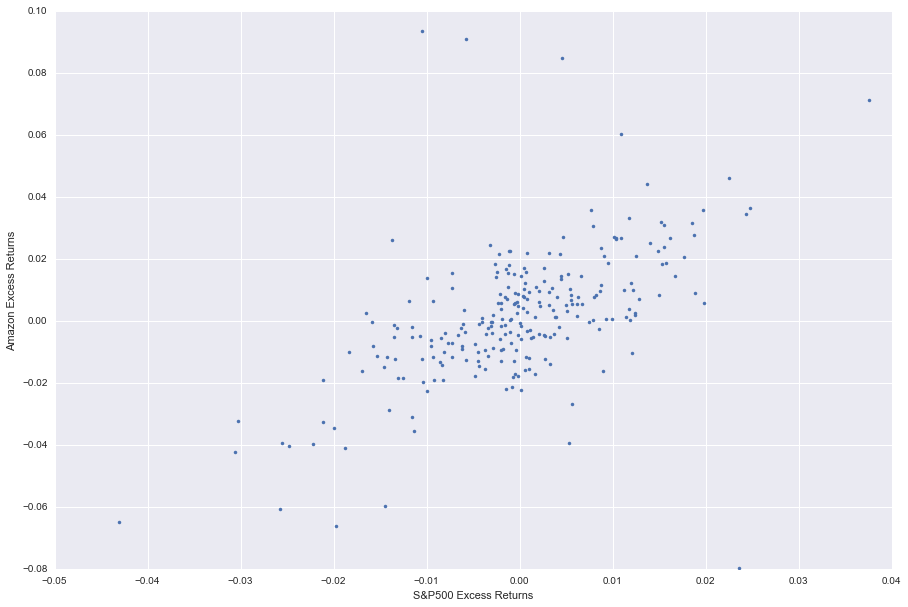

In [56]:
plot_amazon_sp()

## Gaussian Process Regression

In [48]:
gp_model = pf.GPR('Amazon ~ -1 + SP500',kernel_type='SE',
                  data=final_returns)
gp_model.parameters.parameter_list[2].start = -4.0
x = gp_model.fit()

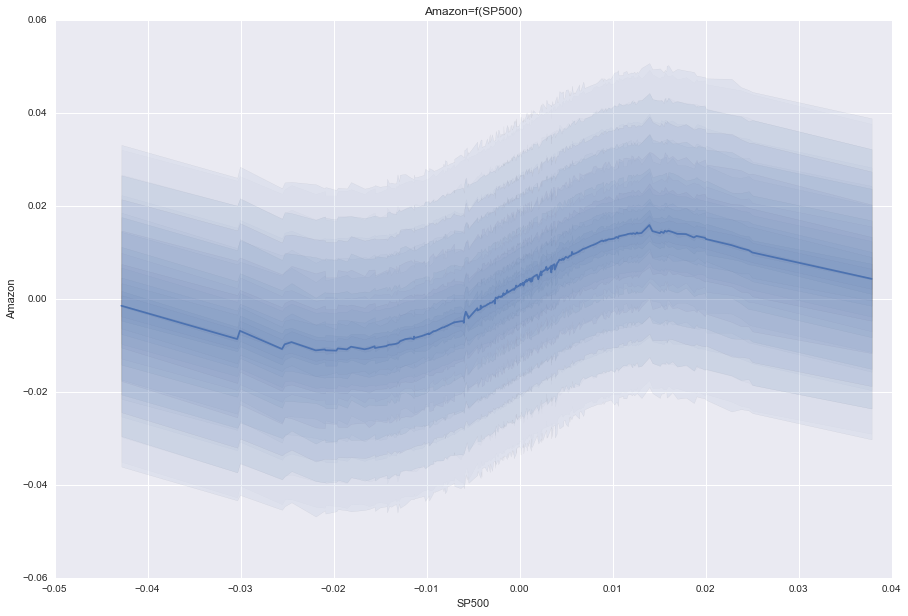

In [49]:
gp_model.plot_oned()

- Need more (useful) tail data? -> online data addition/deletion

In [106]:
a = DataReader('JPM',  'yahoo', datetime(2012,1,1), datetime(2016,6,1))
a_returns = pd.DataFrame(np.diff(np.log(a['Adj Close'].values)))
a_returns.index = a.index.values[1:a.index.values.shape[0]]
a_returns.columns = ["JPM Returns"]

spy = DataReader('SPY',  'yahoo', datetime(2012,1,1), datetime(2016,6,1))
spy_returns = pd.DataFrame(np.diff(np.log(spy['Adj Close'].values)))
spy_returns.index = spy.index.values[1:spy.index.values.shape[0]]
spy_returns.columns = ['S&P500 Returns']

one_mon = DataReader('DGS1MO', 'fred',datetime(2012,1,1), datetime(2016,6,1))
one_day = np.log(1+one_mon)/365

returns = pd.concat([one_day,a_returns,spy_returns],axis=1).dropna()
excess_m = returns["JPM Returns"].values - returns['DGS1MO'].values
excess_spy = returns["S&P500 Returns"].values - returns['DGS1MO'].values
final_returns = pd.DataFrame(np.transpose([excess_m,excess_spy, returns['DGS1MO'].values]))
final_returns.columns=["JPM","SP500","Risk-free rate"]
final_returns.index = returns.index

## JPMorgan Absolute Returns

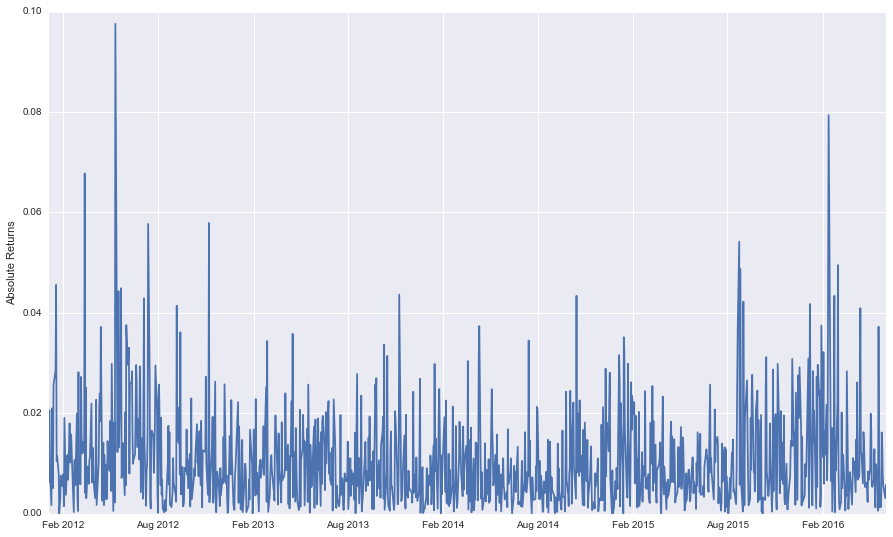

In [107]:
plt.figure(figsize=(15,9))
plt.plot(np.abs(final_returns['JPM']))
plt.ylabel('Absolute Returns');

## Beta-t-EGARCH

In [108]:
model = pf.EGARCH(final_returns,p=1,q=1,target='JPM')
x = model.fit()

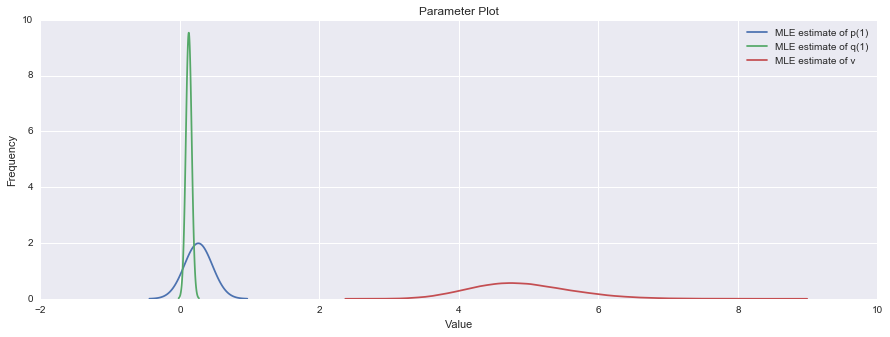

In [109]:
model.plot_parameters([1,2,3])

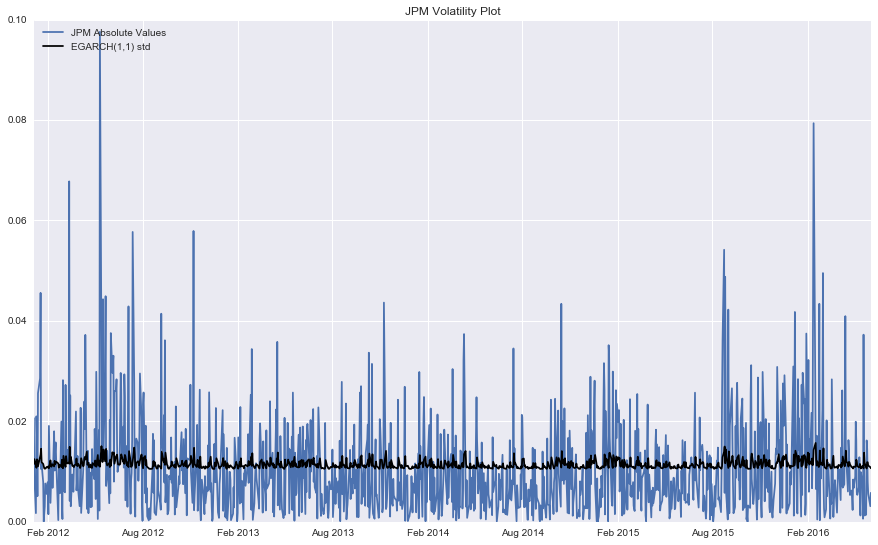

In [111]:
model.plot_fit(figsize=(15,9))

### Leverage Effect

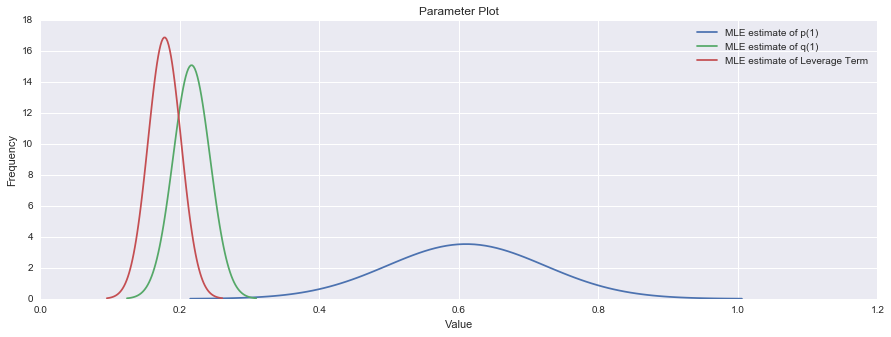

In [112]:
model.add_leverage()
x2 = model.fit()
model.plot_parameters([1,2,3])

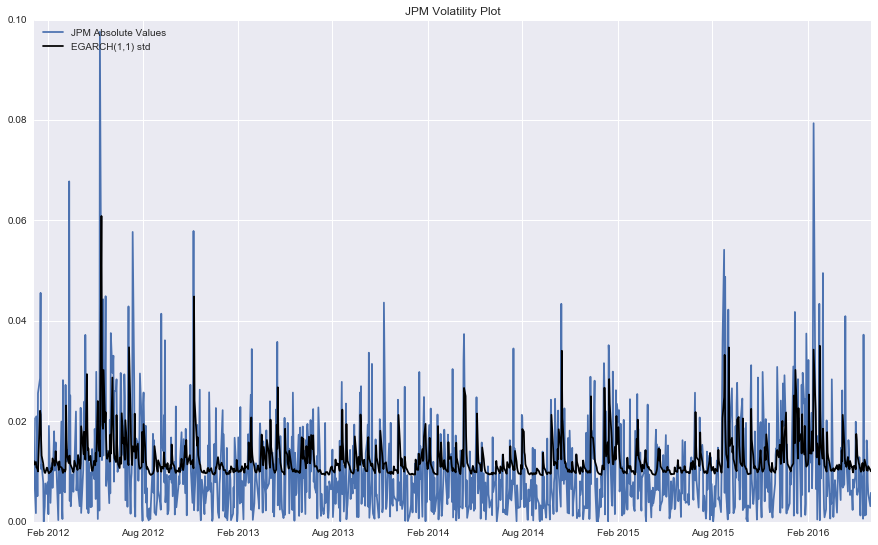

In [114]:
model.plot_fit(figsize=(15,9))

## Thoughts on Further Models

- We may need to look beyond GLM-based frameworks. (GPs)
- How to combine kernel methods and time series? (GP-SSMs)
- Can we do better than GARCH-based or SV models? (GP-Vol)

# Summary

I have demonstrated some examples of time series models and how to use them in PyFlux:

- Score-driven models
- Gaussian state space models
- Non-Gaussian state space models

## Limitations

- **Speed** - written in Python/NumPy; next stage is to Cythonize.


- **Still alpha software** - needs more testing!


- **Other** - model starting values, inference options, refactoring.

# Some books if you found this talk interesting

<img src="mandelbrot.jpg", align="left",width='266',height='400'><img src="harvey.jpg", align="right"width='266',height='400'>

## Finally

<img src="outatime.png", align="center">

If you would like to get involved with this project, talk to me afterwards or DM me at [@rosstaylor90](http://www.twitter.com/rosstaylor90). 

Thank you for listening! :)